          Date   Price
0   2024-01-02  2073.4
1   2024-01-03  2042.8
2   2024-01-04  2050.0
3   2024-01-05  2049.8
4   2024-01-06  2049.8
..         ...     ...
195 2024-07-15  2428.9
196 2024-07-16  2467.8
197 2024-07-17  2459.9
198 2024-07-18  2456.4
199 2024-07-19  2399.1

[200 rows x 2 columns]
Ethereum Prices:
[3504.42 3425.94 3387.81 3442.99 3484.78 3243.5  3175.1  3133.33 3099.82
 3101.17 3065.11 3019.64 2930.48 3068.79 2981.4  3057.81 3295.13 3421.71
 3442.67 3437.84 3378.6  3380.15 3450.45 3370.72 3395.03 3352.29 3420.84
 3495.87 3518.03 3512.91 3561.3  3484.55 3511.52 3625.11 3568.72 3481.84
 3470.15 3559.95 3498.   3667.85 3706.32 3681.59 3678.37 3812.95 3865.14
 3810.35 3767.1  3782.08 3815.95 3762.66 3747.55 3769.57 3845.56 3894.33
 3826.02 3749.28 3728.21 3785.65 3739.08 3790.46 3661.07 3072.08 3122.87
 3092.75 2944.99 3034.71 2881.99 2951.01 2929.35 2912.56 2909.86 3036.32
 2974.94 3006.36 3062.03 3136.4  3117.23 3102.25 2987.12 2973.27 3014.41
 3216.29 3261.69 3255.57 3

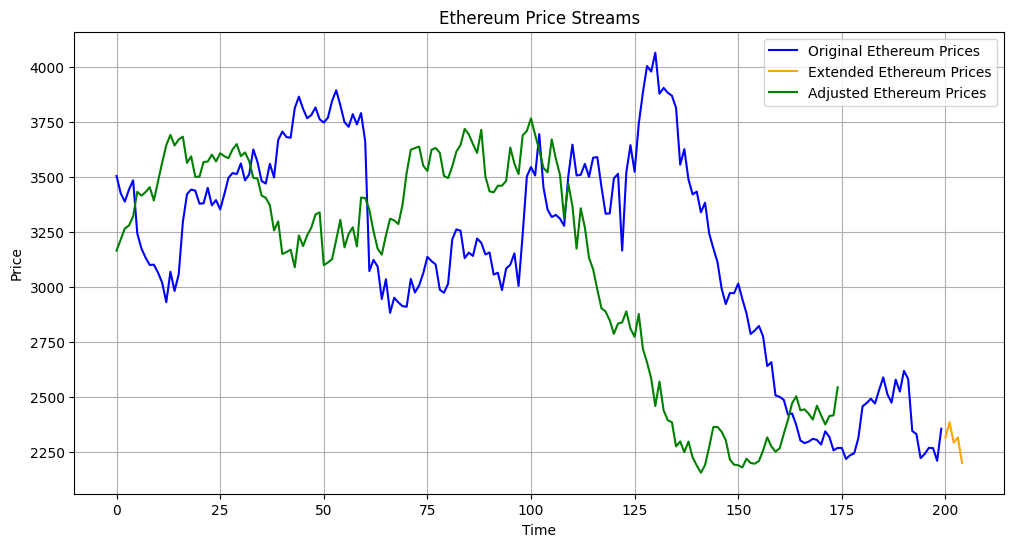

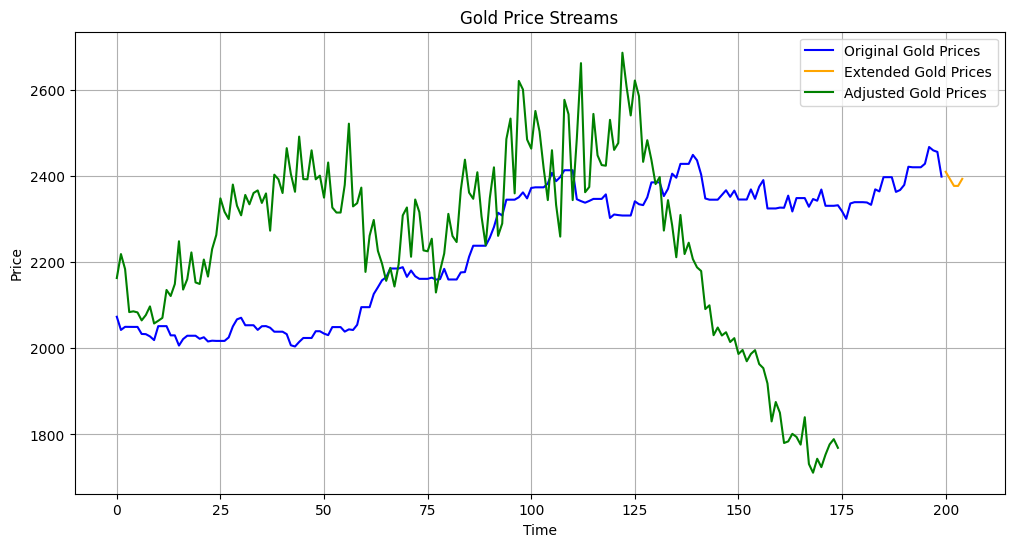

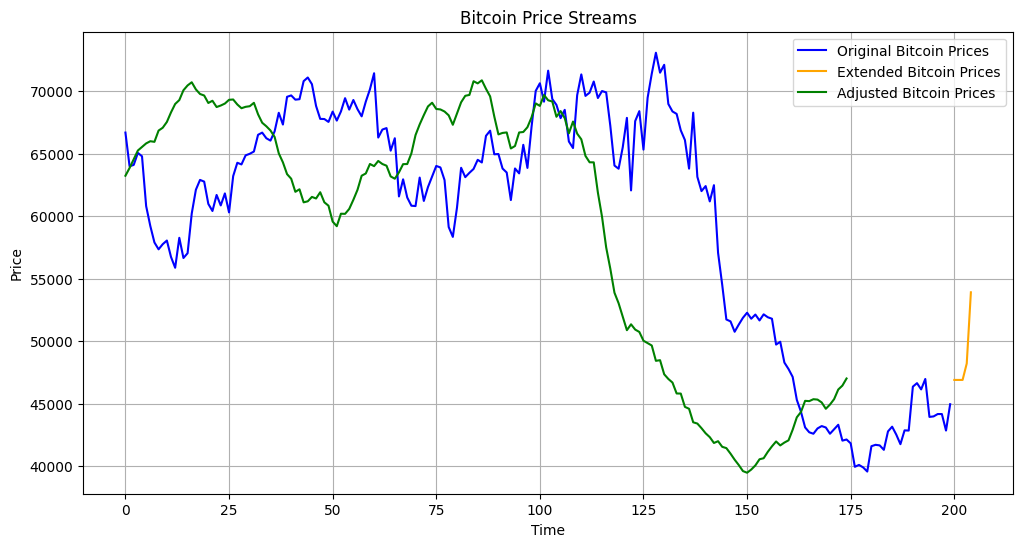

In [4]:
import pandas as pd
import numpy as np
import torch
from torch import nn, optim
from chronos import ChronosPipeline
import matplotlib.pyplot as plt

# Load the datasets
ethereum_path = "data_files/ethereum_prices.csv"
gold_path = "/data_files/gold_prices.csv"
bitcoin_path = "/data_files/bitcoin_prices.csv"

ethereum_df = pd.read_csv(ethereum_path)
gold_df = pd.read_csv(gold_path)
bitcoin_df = pd.read_csv(bitcoin_path)



#------------

# Convert the 'Date' column to datetime format
gold_df['Date'] = pd.to_datetime(gold_df['Date'])

# Set the 'Date' column as the index
gold_df.set_index('Date', inplace=True)

# Create a date range from the minimum to the maximum date in the gold dataset
full_date_range = pd.date_range(start=gold_df.index.min(), end=gold_df.index.max())

# Reindex the gold dataframe to include all dates, filling missing dates with NaN
gold_df = gold_df.reindex(full_date_range)

# Forward fill missing prices
gold_df['Price'] = gold_df['Price'].ffill()

# Reset index to have 'Date' as a column again
gold_df.reset_index(inplace=True)
gold_df.rename(columns={'index': 'Date'}, inplace=True)

# Print the updated gold prices dataframe
print(gold_df)

# Extract the 'Price' columns as numpy arrays
ethereum_prices = ethereum_df['Price'].values
gold_prices = gold_df['Price'].values
bitcoin_prices = bitcoin_df['Price'].values
print('Ethereum Prices:')
print(ethereum_prices)

print('Gold Prices:')
print(gold_prices)

print('Bitcoin Prices:')
print(bitcoin_prices)

# Convert the streams to tensors
ethereum_tensor = torch.tensor(ethereum_prices, dtype=torch.float32)
gold_tensor = torch.tensor(gold_prices, dtype=torch.float32)
bitcoin_tensor = torch.tensor(bitcoin_prices, dtype=torch.float32)

# Initialize the Chronos pipeline
forecast_len = 5
num_samples = 1  # Shared across all predictions
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-large",
    device_map="cpu",  # use "cpu" for CPU inference and "mps" for Apple Silicon
    torch_dtype=torch.bfloat16,
)

# Predict for each individual asset
ethereum_forecast = pipeline.predict(
    context=ethereum_tensor,
    prediction_length=forecast_len,
    num_samples=num_samples,
)

print('Ethereum Forecast:')
print(ethereum_forecast)

gold_forecast = pipeline.predict(
    context=gold_tensor,
    prediction_length=forecast_len,
    num_samples=num_samples,
)

print('Gold Forecast:')
print(gold_forecast)

bitcoin_forecast = pipeline.predict(
    context=bitcoin_tensor,
    prediction_length=forecast_len,
    num_samples=num_samples,
)

print('Bitcoin Forecast:')
print(bitcoin_forecast)

# Convert the forecasts to numpy arrays and flatten
ethereum_forecast_values = ethereum_forecast.squeeze(0).numpy().flatten()
gold_forecast_values = gold_forecast.squeeze(0).numpy().flatten()
bitcoin_forecast_values = bitcoin_forecast.squeeze(0).numpy().flatten()

# Concatenate the predicted values onto the original streams
extended_ethereum = np.concatenate([ethereum_prices, ethereum_forecast_values])
extended_gold = np.concatenate([gold_prices, gold_forecast_values])
extended_bitcoin = np.concatenate([bitcoin_prices, bitcoin_forecast_values])

#!!! INSERT CODE FOR TRAINING FFN ON STREAMS TO ADJUST THEIR VALUES BASED ON INTERPLAY ACROSS THE ASSETS
class MultiInputFFN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MultiInputFFN, self).__init__()
        self.fc1_eth = nn.Linear(input_size, hidden_size)
        self.fc1_gold = nn.Linear(input_size, hidden_size)
        self.fc1_btc = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size * 3, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, eth, gold, btc):
        eth_out = self.relu(self.fc1_eth(eth))
        gold_out = self.relu(self.fc1_gold(gold))
        btc_out = self.relu(self.fc1_btc(btc))
        combined = torch.cat((eth_out, gold_out, btc_out), dim=1)
        out = self.relu(self.fc2(combined))
        out = self.fc3(out)
        return out

# Prepare the training data
sequence_length = 30  # Number of previous days to consider
input_size = sequence_length  # Separate input for each asset stream
hidden_size = 128
output_size = 3  # 3 assets as output

# Create the dataset by combining the streams
def create_separate_datasets(ethereum, gold, bitcoin, seq_length):
    eth_data, gold_data, btc_data = [], [], []
    for i in range(len(ethereum) - seq_length):
        eth_seq = ethereum[i:i+seq_length]
        gold_seq = gold[i:i+seq_length]
        btc_seq = bitcoin[i:i+seq_length]
        eth_data.append(eth_seq)
        gold_data.append(gold_seq)
        btc_data.append(btc_seq)
    return np.array(eth_data), np.array(gold_data), np.array(btc_data)

# Generate the dataset
eth_X, gold_X, btc_X = create_separate_datasets(extended_ethereum, extended_gold, extended_bitcoin, sequence_length)
y = np.column_stack((extended_ethereum[sequence_length:], extended_gold[sequence_length:], extended_bitcoin[sequence_length:]))

# Convert to PyTorch tensors
eth_X_tensor = torch.tensor(eth_X, dtype=torch.float32)
gold_X_tensor = torch.tensor(gold_X, dtype=torch.float32)
btc_X_tensor = torch.tensor(btc_X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Initialize the multi-input FFN model, loss function, and optimizer
model = MultiInputFFN(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    outputs = model(eth_X_tensor, gold_X_tensor, btc_X_tensor)
    loss = criterion(outputs, y_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Use the trained model to adjust the extended streams based on interplay across the assets
model.eval()
with torch.no_grad():
    adjusted_streams = model(eth_X_tensor, gold_X_tensor, btc_X_tensor).numpy()

with torch.no_grad():
    adjusted_streams = model(eth_X_tensor, gold_X_tensor, btc_X_tensor).numpy()

# Split the adjusted streams back into individual assets
adjusted_ethereum = adjusted_streams[:, 0]
adjusted_gold = adjusted_streams[:, 1]
adjusted_bitcoin = adjusted_streams[:, 2]

print('Adjusted Ethereum:')
print(adjusted_ethereum)

print('Adjusted Gold:')
print(adjusted_gold)

print('Adjusted Bitcoin:')
print(adjusted_bitcoin)

# Plotting function
def plot_streams(original, extended, adjusted, asset_name):
    plt.figure(figsize=(12, 6))
    
    # Plot the original prices
    plt.plot(original, label=f'Original {asset_name} Prices', color='blue')
    
    # Plot the extended prices (only the forecasted part)
    plt.plot(range(len(original), len(extended)), extended[len(original):], label=f'Extended {asset_name} Prices', color='orange')
    
    # Plot the adjusted prices corresponding to the original part
    adjusted_original = adjusted[:len(original)]
    plt.plot(range(len(adjusted_original)), adjusted_original, label=f'Adjusted {asset_name} Prices', color='green')
    
    # Plot the adjusted prices corresponding to the forecasted part
    adjusted_forecast = adjusted[len(original):]
    #plt.plot(range(len(original), len(extended)), adjusted_forecast, label=f'Adjusted Forecast {asset_name} Prices', color='red')
    
    plt.title(f'{asset_name} Price Streams')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot Ethereum
plot_streams(ethereum_prices, extended_ethereum, adjusted_ethereum, 'Ethereum')

# Plot Gold
plot_streams(gold_prices, extended_gold, adjusted_gold, 'Gold')

# Plot Bitcoin
plot_streams(bitcoin_prices, extended_bitcoin, adjusted_bitcoin, 'Bitcoin')


In [ ]:
help(pipeline.predict)